In [2]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

def is_converged(a, b) -> bool:
    epsilon = 1e-8
    return np.sum(np.abs(a - b)) < epsilon

def q_table_directions_map(q_table: np.ndarray, map_size):
    """Get the best learned action & map it to arrows."""
    q_table_val_max = q_table.max(axis=1).reshape(map_size, map_size)
    q_table_best_action = np.argmax(q_table, axis=1)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    eps = np.finfo(float).eps  # Minimum float number on the machine
    q_table_directions = np.array([directions[e] if e > eps else '' for e in q_table_best_action]).reshape(map_size, map_size)

    return q_table_val_max, q_table_directions

def plot_q_values_map(q_table :np.ndarray, env, map_size, is_show=True, name='', save_img=False, save_path=''):
    """Plot the last frame of the simulation and the policy learned."""
    q_table_val_max, q_table_directions = q_table_directions_map(q_table, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        q_table_val_max,
        annot=q_table_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title=f"{name}")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")

    if save_img:
        img_title = name + ' ' + f"frozenlake_q_values_{map_size}x{map_size}.png"
        fig.savefig(save_path + img_title, bbox_inches="tight")

    if is_show:
        plt.show()

def postprocess(episodes, runs, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    episodes = np.arange(episodes)
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

def plot_steps_and_rewards(rewards_df, steps_df, name='', is_show=True, is_save=False, save_path=''):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = name + ' ' + "frozenlake_steps_and_rewards.png"
    if is_save:
        fig.savefig(save_path + img_title, bbox_inches="tight")
    if is_show:
        plt.show()

class DP:
    def __init__(self, size, gamma, epsilon, desc) -> None:
        self.size = self.nrow = self.ncol = size
        self.action_space = 4
        self.state_space = self.nrow * self.ncol
        self.gamma = gamma
        self.epsilon = epsilon

        position_rewards = np.zeros(desc.shape)
        position_rewards[desc == b'G'] = 1
        position_rewards[desc == b'H'] = -1

        state_action_reward = []
        for row in range(self.nrow):
            for col in range(self.ncol):
                actions_rewards = []
                for action in range(self.action_space):
                    next_position = self.inc(row, col, action)
                    action_reward = position_rewards[next_position]
                    actions_rewards.append(action_reward)
                state_action_reward.append(actions_rewards)

        self.state_action_reward = np.array(state_action_reward)

    def line_to_maze(self, n:int):
        row = n // self.ncol
        col = n % self.ncol
        return row, col

    def maze_to_line(self, row, col):
        n = row * self.ncol + col
        return n

    def inc(self, row, col, action):
        match action:
            case 0:
                col = max(col-1, 0)
            case 1:
                row = min(row+1, self.nrow-1)
            case 2:
                col = min(col+1, self.ncol-1)
            case 3:
                row = max(row-1, 0)
        return (row, col)

    def inc_line_to_line(self, state, action):
        row, col = self.line_to_maze(state)
        new_row, new_col = self.inc(row, col, action)
        state = self.maze_to_line(new_row, new_col)
        return state


    def calculation_q_table(self, values):
        # q_table = immediate reward + action state values * gamma
        q_table = self.state_action_reward.copy()    # immediate reward
        for state in range(self.state_space):
            for action in range(self.action_space):
                next_state = self.inc_line_to_line(state, action)
                q_table[state, action] += self.gamma * values[next_state]    # action state values * gamma
        return q_table
    
    def interaction(self, env:gym.Env, policy):
        observation, info = env.reset()
        done = False
        while not done:
            action = policy[observation]
            observation, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated

    def value_interation(self):
        values_record = [np.zeros((self.state_space))]
        policy_record = [np.zeros(self.state_space)]

        q_table = np.zeros((self.state_space, self.action_space))

        # interation
        while True:
            q_table = self.calculation_q_table(values_record[-1])
            policy_record.append(np.argmax(q_table, axis=1))
            new_values = np.max(q_table, axis=1)
            if is_converged(new_values, values_record[-1]):
                break
            values_record.append(new_values)
        
        return values_record, policy_record, q_table

    def policy_interation(self):
        policy_record = [np.random.randint(0, self.action_space, size=self.state_space)]
        values_record = [np.random.random(self.state_space)]

        while True:
            # Policy evaluation
            values_pi = values_record[-1].copy()
            while True:
                new_values_pi = np.zeros(self.state_space)
                for state in range(self.state_space):
                    action = policy_record[-1][state]
                    new_state = self.inc_line_to_line(state, action)
                    new_values_pi[state] = self.state_action_reward[state, action] + self.gamma *values_pi[new_state]

                if is_converged(values_pi, new_values_pi):
                    break
                values_pi = new_values_pi.copy()
            if is_converged(values_pi, values_record[-1]):
                break
            values_record.append(values_pi)

            # Policy improvement
            q_table = self.calculation_q_table(values_record[-1])
            policy_record.append(np.argmax(q_table, axis=1))
            
        return values_record, policy_record, q_table
    
class Qlearning:
    def __init__(self, env:gym.Env, alpha, epsilon, gamma) -> None:
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.reset_q_table()

    def reset_q_table(self):
        self.q_table = np.zeros((self.env.observation_space.n,
                                 self.env.action_space.n))
        
    def update(self, state, action, reward, new_state):
        delta = (
            reward
            + self.gamma * np.max(self.q_table[new_state, :])
            - self.q_table[state, action]
        )
        self.q_table[state, action] += self.alpha * delta

    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            max_ids, *_ = np.where(self.q_table[state,:]
                                   == np.max(self.q_table[state, :]))
            action = np.random.choice(max_ids)
        return action
    
    def run(self, runs, episodes):
        rewards = np.zeros((episodes, runs))
        steps = np.zeros((episodes, runs))
        q_tables = []
        all_states = []
        all_actions = []
        
        for run in range(runs):
            self.reset_q_table()
            for episode in range(episodes):
                step = 0
                total_rewards = 0
                obs, info = self.env.reset()
                terminated = truncated = False
                while not terminated and not truncated:
                    action = self.choose_action(obs)
                    next_obs, reward, terminated, truncated, info = self.env.step(action)
                    self.update(obs, action, reward, next_obs)

                    all_states.append(obs)
                    all_actions.append(action)
                    total_rewards += reward
                    step += 1

                    obs = next_obs
                rewards[episode, run] = total_rewards
                steps[episode, run] = step
            q_tables.append(self.q_table)
        q_tables = np.array(q_tables)
        return rewards, steps, q_tables, all_states, all_actions
    
class SARSA:
    def __init__(self, env:gym.Env, alpha, epsilon, gamma) -> None:
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.reset_q_table()

    def reset_q_table(self):
        self.q_table = np.zeros((self.env.observation_space.n,
                                 self.env.action_space.n))
        
    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            max_ids, *_ = np.where(self.q_table[state, :] 
                                   == np.max(self.q_table[state, :]))
            action = np.random.choice(max_ids)
        return action
    
    def update(self, state, action, reward, next_state, next_action):
        delta = self.q_table[state, action] \
                - (reward + self.gamma * self.q_table[next_state, next_action])

        self.q_table[state, action] -= self.alpha * delta  

    def run(self, runs, episodes):
        rewards = np.zeros((episodes, runs))
        steps = np.zeros((episodes, runs))
        q_tables = []
        all_states = []
        all_actions = []

        for run in range(runs):
            self.reset_q_table()
            for episode in range(episodes):
                step = 0
                total_rewards = 0
                obs, info = self.env.reset()
                action = self.choose_action(obs)
                terminated = truncated = False
                while not terminated and not truncated:
                    next_obs, reward, terminated, truncated, info = self.env.step(action)

                    all_states.append(obs)
                    all_actions.append(action)
                    total_rewards += reward
                    step += 1

                    next_action = self.choose_action(next_obs)
                    self.update(obs, action, reward, next_obs, next_action)

                    action, obs = next_action, next_obs
                
                rewards[episode, run] = total_rewards
                steps[episode, run] = step
            q_tables.append(self.q_table)
        q_tables = np.array(q_tables)

        return rewards, steps, q_tables, all_states, all_actions

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


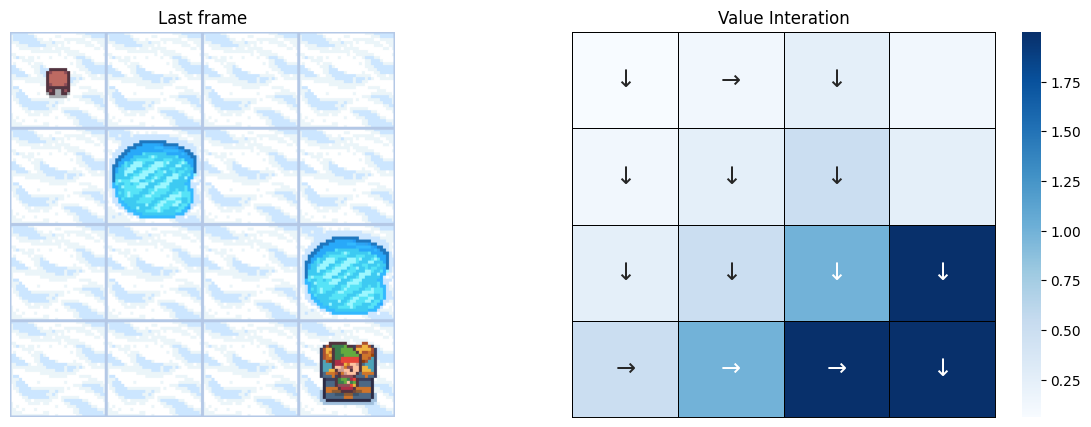

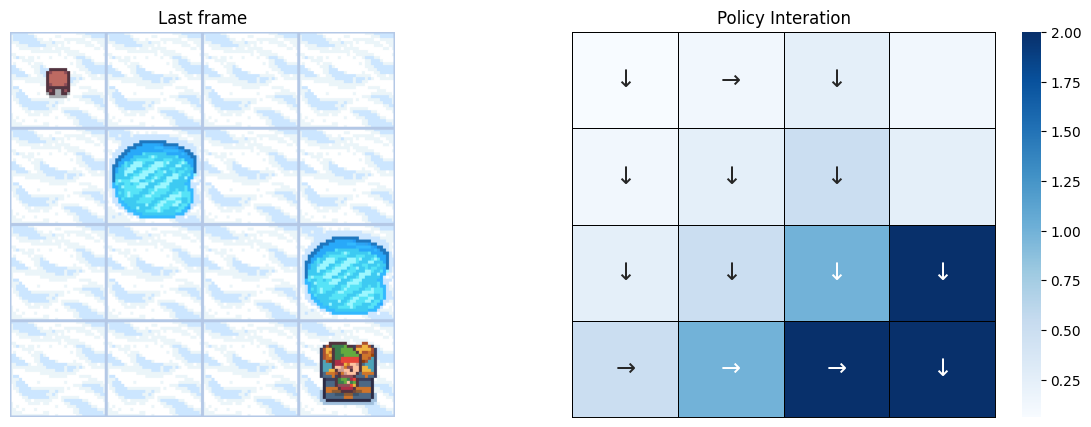

In [ ]:
def value_policy():
    is_show=False
    map_sizes = [4, 7, 9]
    save_path = './img/'
    for size in tqdm(map_sizes):
        desc = np.asarray(generate_random_map(size=size, seed=42, p=0.9), dtype='c')
        env = gym.make('FrozenLake-v1',
                        is_slippery=False,
                        render_mode='rgb_array',
                        desc=desc,
                        )
        
        dp = DP(size, gamma=0.5, epsilon=1e-8, desc=desc)
        # Value Interaction
        values_record, policy_record, q_table = dp.value_interation()
        policy = policy_record[-1]
        env.reset()
        dp.interaction(env, policy)
        plot_q_values_map(q_table, env, size, is_show=is_show, name="Value Interation", save_img=True, save_path=save_path)


        # Policy Interaction
        values_record, policy_record, q_table = dp.policy_interation()
        policy = policy_record[-1]
        env.reset()
        dp.interaction(env, policy)
        plot_q_values_map(q_table, env, size, is_show=is_show, name="Policy Interation", save_img=True, save_path=save_path)

value_policy()

100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


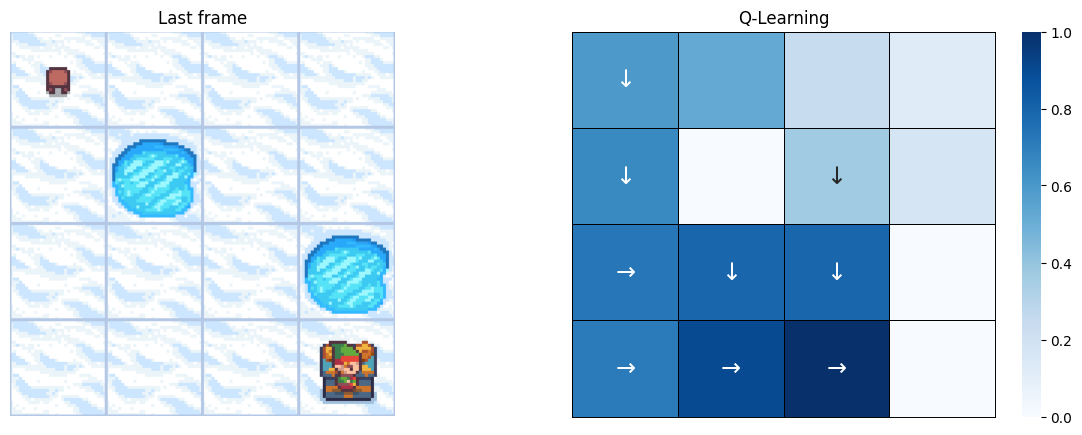

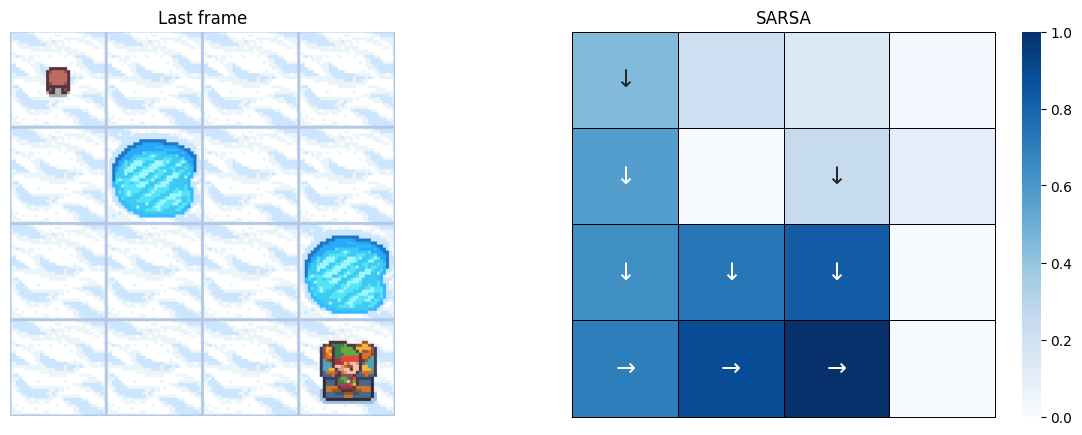

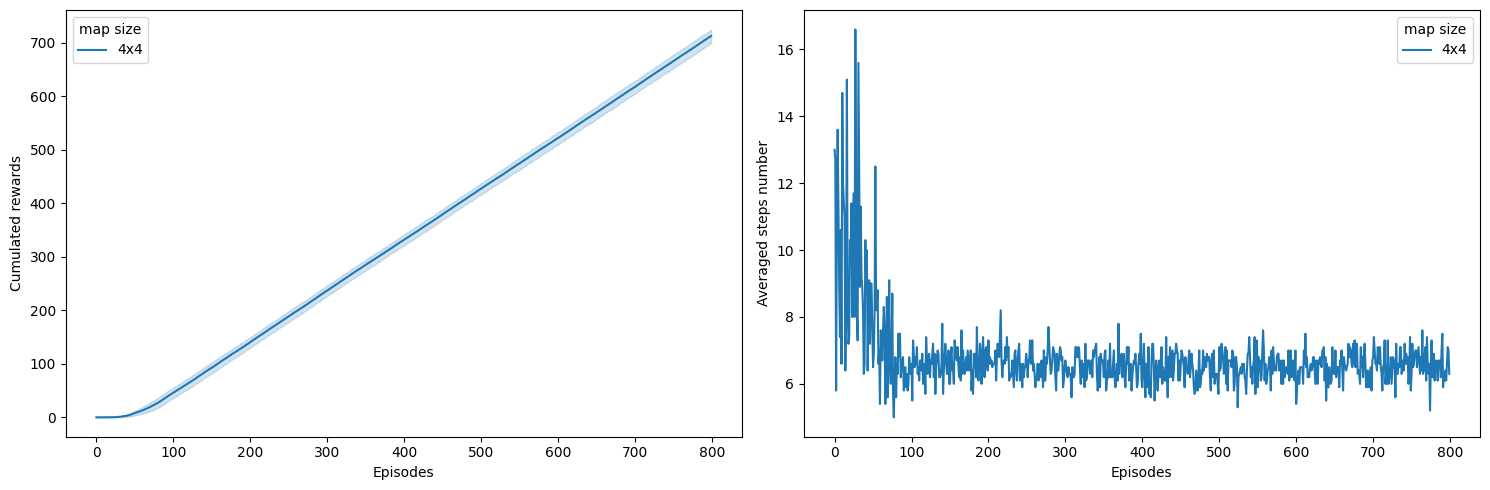

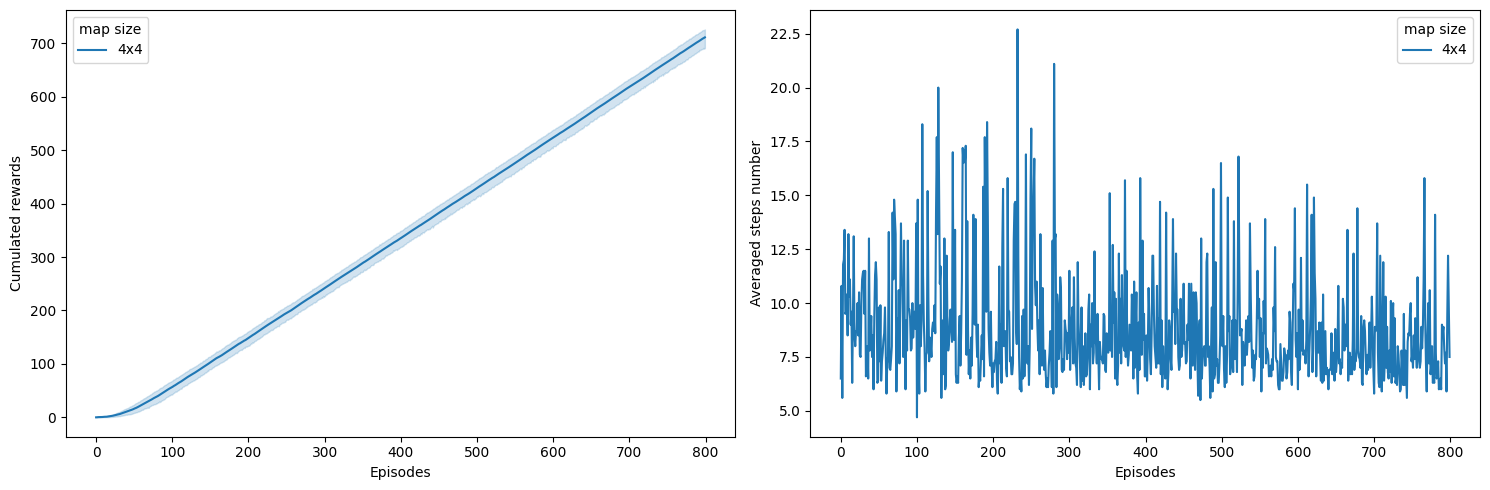

In [ ]:
def qlearning_sarsa():
    res_all = {'Q-Learning':pd.DataFrame(), 'SRASA':pd.DataFrame()}
    st_all = {'Q-Learning':pd.DataFrame(), 'SRASA':pd.DataFrame()}
    n_runs = 10
    total_episodes = 800
    is_show = False
    map_sizes = [4, 7, 9]
    save_path = './img/'
    for size in tqdm(map_sizes):
        desc = np.asarray(generate_random_map(size=size, seed=42, p=0.9), dtype='c')
        env = gym.make('FrozenLake-v1',
                        is_slippery=False,
                        render_mode='rgb_array',
                        desc=desc,
                        )

        # Q-Learning
        agent = Qlearning(env, alpha=0.8, epsilon=0.1, gamma=0.9)
        rewards, steps, q_tables, all_states, all_actions = agent.run(runs=n_runs, episodes=total_episodes)
        q_table = q_tables.mean(axis=0)
        plot_q_values_map(q_table, env, size, is_show=is_show, name="Q-Learning", save_img=True, save_path=save_path)

        res, st = postprocess(total_episodes, n_runs, rewards, steps, size)
        res_all['Q-Learning'] = pd.concat([res_all['Q-Learning'], res])
        st_all['Q-Learning'] = pd.concat([st_all['Q-Learning'], st])

        # SARSA
        agent = SARSA(env, alpha=0.8, epsilon=0.1, gamma=0.9)
        rewards, steps, q_tables, all_states, all_actions = agent.run(runs=n_runs, episodes=total_episodes)
        q_table = q_tables.mean(axis=0)
        plot_q_values_map(q_table, env, size, is_show=is_show, name="SARSA", save_img=True, save_path=save_path)

        res, st = postprocess(total_episodes, n_runs, rewards, steps, size)
        res_all['SRASA'] = pd.concat([res_all['SRASA'], res])
        st_all['SRASA'] = pd.concat([st_all['SRASA'], st])

    env.close()

    plot_steps_and_rewards(res_all['Q-Learning'], st_all['Q-Learning'], name="Q-Learning", is_show=False, is_save=True, save_path=save_path)

    plot_steps_and_rewards(res_all['SRASA'], st_all['SRASA'], name='SARSA', is_show=False, is_save=True, save_path=save_path)

qlearning_sarsa()